In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150

In [2]:
import os
import fitsio
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from astropy.io import ascii
import matplotlib.pyplot as plt

from itertools import combinations_with_replacement

from dr25 import dr25

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Start by defining some useful quantities:

In [3]:
session = tf.Session()
durations = np.array([1.5, 2.0, 2.5, 3.0, 3.5, 4.5, 5.0, 6.0, 7.5, 9.0, 10.5, 12.0, 12.5, 15.0])
cdpp_cols = ["rrmscdpp01p5", "rrmscdpp02p0", "rrmscdpp02p5", "rrmscdpp03p0",
             "rrmscdpp03p5", "rrmscdpp04p5", "rrmscdpp05p0", "rrmscdpp06p0",
             "rrmscdpp07p5", "rrmscdpp09p0", "rrmscdpp10p5", "rrmscdpp12p0",
             "rrmscdpp12p5", "rrmscdpp15p0"]
max_period = 100.0

Load the stellar properties table and select a subset.

In [4]:
berger = pd.read_csv("data/DR2PapTable1.txt", sep="&")
stlr = ascii.read("data/q1_q17_dr25_stellar.txt").to_pandas()
stlr = pd.merge(berger, stlr, left_on="KIC", right_on="kepid", suffixes=("", "_stlr"))

# Only select dwarfs
m = (4200 <= stlr.teff) & (stlr.teff <= 6100)
m &= stlr.rad <= 1.15
m &= stlr["class\\\\"] == "0\\\\"

# Only include stars with sufficient data coverage.
m &= stlr.dataspan > 365.25*2.
m &= stlr.dutycycle > 0.6
m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with logg estimates.
m &= np.isfinite(stlr.logg)

stlr = pd.DataFrame(stlr[m])
print("selected {0} stars".format(len(stlr)))

selected 54837 stars


Load the flux level transit injections for each star

In [5]:
def get_flti_filename(kicid):
    kid_str = "{0:09d}".format(kicid)
    path = os.path.join("data", "FLTI-DR25-KSOC-5006")
    return os.path.join(path, "kplr{0}_dr25_5006_flti.fits".format(kid_str))

hdr_keys = [
    "KEPLERID", "RADIUS", "TEFF", "LOGG", "FEH",
    "LIMBD1", "LIMBD2", "LIMBD3", "LIMBD4",
]
datasets = []
ntargets = 0
for _, star in tqdm(stlr.iterrows(), total=len(stlr)):
    fn = get_flti_filename(int(star.kepid))
    if not os.path.exists(fn):
        continue
    ntargets += 1
    data = fitsio.read(fn)
    m = data["Period"] < max_period
    # m &= data["exp_mes"] < 50.0
    data = data[m]
    df = pd.DataFrame.from_records(data.byteswap().newbyteorder())
    hdr = fitsio.read_header(fn, 0)
    for c in hdr_keys:
        df[c.lower()] = hdr[c]
    datasets.append(df)
flti = pd.concat(datasets)
del datasets

cols = cdpp_cols + ["kepid", "rad", "teff", "logg", "dataspan", "dutycycle", "cdppslplong", "cdppslpshrt"]
flti = pd.merge(flti, stlr[cols], left_on="keplerid", right_on="kepid", suffixes=("flti", ""))

print("loaded {0} injections for {1} targets".format(len(flti), ntargets))

100%|██████████| 54837/54837 [01:48<00:00, 504.97it/s]


loaded 9950082 injections for 9239 targets


Compare the stellar catalog and the stars with injections

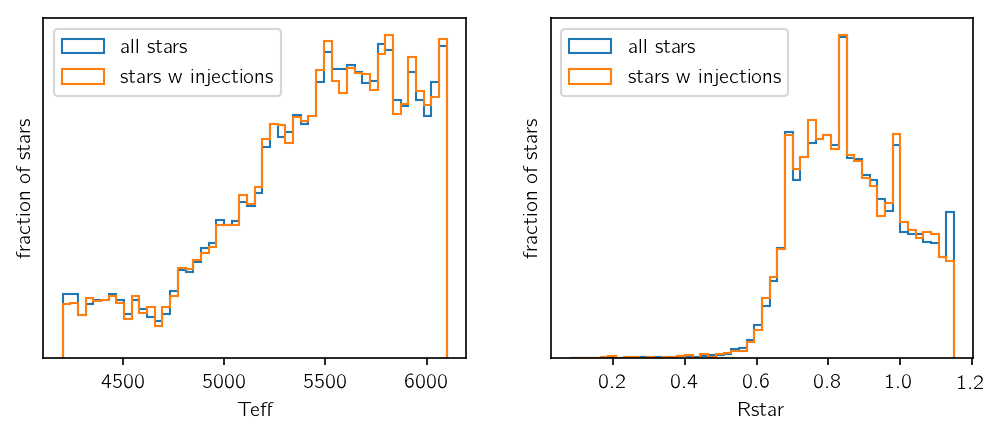

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

ax = axes[0]
n, bins, _ = ax.hist(stlr.teff, 50, histtype="step", label="all stars", density=True)
ax.hist(flti.groupby("kepid").mean().teff, bins, histtype="step", label="stars w injections", density=True)
ax.set_xlabel("Teff")
ax.set_ylabel("fraction of stars")
ax.set_yticks([])
ax.legend(loc=2)

ax = axes[1]
n, bins, _ = ax.hist(stlr.rad, 50, histtype="step", label="all stars", density=True)
ax.hist(flti.groupby("kepid").mean().rad, bins, histtype="step", label="stars w injections", density=True)
ax.set_xlabel("Rstar")
ax.set_ylabel("fraction of stars")
ax.set_yticks([])
ax.legend(loc=2);

Find the best fit quadratic limb darkening approximation for each injection

In [7]:
c = np.array(flti[["limbd1", "limbd2", "limbd3", "limbd4"]], dtype=float)
b = np.array(flti.b)
ror = 0.009158*np.array(flti.Rp / flti.radius)
# r = np.clip(b, 1e-5, 1-1e-5)
r = 0.5+np.zeros_like(b)
mu = np.sqrt(1.0 - r**2)
u = np.array([1.0 - mu, (1.0 - mu)**2])
w = np.array([1.0 - np.sqrt(mu), 1.0 - mu, 1.0 - mu**1.5, 1.0 - mu**2]).T
norm = np.sum(u**2, axis=0)
f = np.sum(c * w, axis=1)
m = norm > 0
f[m] /= norm[m]
gamma = f[:, None] * u.T
gamma[~m] = 0.5

Load the pixel level injections and Robovetter classifications

In [8]:
# Load the injections
inj = ascii.read("data/kplr_dr25_inj1_plti.txt").to_pandas()
inj["kepid"] = inj.KIC_ID.astype(int)
m = inj.i_depth > 0.0
m &= inj.i_period < max_period
m &= inj.EB_injection < 1.0
m &= inj.Offset_from_source < 1.0
inj = inj[m]

# Load the robovetter results
robo = ascii.read("data/kplr_dr25_inj1_tces.txt").to_pandas()

# Only select the injections in our subsample
inj = pd.merge(inj, stlr, on="kepid", suffixes=("", "_stlr"))
inj = pd.merge(inj, robo, how="left", suffixes=("", "_robo"), on="TCE_ID")
m1 = inj.Recovered > 0
m2 = inj.Disp == "PC"
robo_eff = m2.sum() / m1.sum()

print("selected {0} pixel-level injections".format(len(inj)))
print("average robovetter efficiency: {0:.1f}%".format(100*robo_eff))

selected 8170 pixel-level injections
average robovetter efficiency: 93.8%


Build the completeness model in TF

In [9]:
b_grid = np.linspace(0, 1, 10)

In [17]:
T = tf.float64

R_star = tf.placeholder(T, (None,), name="R_star")
logg_star = tf.placeholder(T, (None,), name="logg_star")
gamma_star = tf.placeholder(T, (None, 2), name="gamma_star")
cdpp_star = tf.placeholder(T, (None, len(durations)), name="cdpp_star")
dataspan_star = tf.placeholder(T, (None,), name="dataspan_star")
dutycycle_star = tf.placeholder(T, (None,), name="dutycycle_star")
R_pl = tf.placeholder(T, (None,), name="R_pl")
P_pl = tf.placeholder(T, (None,), name="P_pl")
b_pl = tf.zeros_like(P_pl, dtype=T)  # tf.placeholder(T, (None,), name="b_pl")

# Completeness model
log_beta_params = tf.Variable(np.log([2.651862971, 0.4]), dtype=T, name="log_beta_params")
comp_norm = tf.Variable(0.996, dtype=T, name="comp_norm")
mes0 = tf.Variable(8.0, dtype=T, name="mes0")
log_sig_mes = tf.Variable(-5.0, dtype=T, name="log_sig_mes")

# mes0_p = tf.Variable([4.74, -0.54, 2.04, 0.15, -2.89], dtype=T, name="mes0")
# log_sig_mes_p = tf.Variable([-0.59,  0.12,  0.35, -2.59], dtype=T, name="log_sig_mes")

comp_pars = [comp_norm, log_sig_mes, mes0, log_beta_params]

# comp_pars = tf.Variable([0.95, np.log(4.0), np.log(2.0)], dtype=T, name="comp_pars")
recovered = tf.placeholder(T, (None,), name="recovered")

# Estimate the transit properties
ror_pl = R_pl / R_star
M_star = 10.0**(logg_star-4.437) * tf.square(R_star)
a_pl = 215.0 * M_star**(1.0/3.0) * (P_pl/365.25)**(2.0/3.0)
a_pl_sin_i = tf.sqrt(tf.square(a_pl) - tf.square(R_star * 0.5))  # <-- b = 0.5
tau_pl = P_pl * tf.asin(R_star * tf.sqrt((1.0+ror_pl)**2 - 0.5**2) / a_pl_sin_i) / np.pi  # <-- b = 0.5

depth = (1.0 - dr25.quad(gamma_star[:, 0], gamma_star[:, 1], ror_pl, b_grid[None, :] + tf.zeros_like(ror_pl)[:, None])) * 1e6

# The completeness model should be a function of duration
# x = b_pl
# mes0_lin = mes0_p[0] + mes0_p[1] * x + mes0_p[2] * tf.square(x)
# mes0 = mes0_lin - (mes0_p[3] - mes0_lin) * tf.exp((x-1)*tf.exp(-mes0_p[4]))
# log_sig_mes_lin = log_sig_mes_p[0] + log_sig_mes_p[1] * x
# log_sig_mes = log_sig_mes_lin + (log_sig_mes_p[2] - log_sig_mes_lin) * tf.exp((x-1)*tf.exp(-log_sig_mes_p[3]))

# Interpolate the CDPP grid
cdpp = dr25.interp(tau_pl, durations, cdpp_star)

# Estimate the MES
ntran = dataspan_star * dutycycle_star / P_pl
factor = tf.sqrt(ntran) / cdpp
mes = factor[:, None] * depth

# Completeness as a function of MES
# pdet = tf.where(mes > mes0,
#                 comp_norm * tf.igamma(tf.exp(log_alpha), tf.exp(log_beta)*tf.abs(mes - mes0)),
#                 tf.zeros_like(mes))
pdet_all = comp_norm / (1.0 + tf.exp(-(mes - mes0) * tf.exp(-log_sig_mes)))
# pdet_all *= norm * b_vals[None, :]
pdet = tf.reduce_sum(0.5 * (pdet_all[:, 1:] + pdet_all[:, :-1]) * np.diff(b_grid)[None, :], axis=1)
pdet = tf.clip_by_value(pdet, 0.0, 1.0)

# Fit completeness parameters to injections
chi2 = tf.norm(pdet - recovered)
opt = tf.contrib.opt.ScipyOptimizerInterface(chi2, comp_pars)

session.run(tf.global_variables_initializer())

feed = {
    R_star: np.array(flti.rad),
    logg_star: np.array(flti.logg),
    gamma_star: gamma,
    cdpp_star: np.array(flti[cdpp_cols]),
    dataspan_star: np.array(flti.dataspan),
    dutycycle_star: np.array(flti.dutycycle),
    R_pl: ror * np.array(flti.rad),
    P_pl: np.array(flti.Period),
#     b_pl: np.array(flti.b),
    recovered: np.array((flti.Recovered == 1), dtype=float),
}

# print("Initial chi2: {0}".format(session.run(chi2, feed_dict=feed)))

In [18]:
p = np.linspace(0, 30, 500)
plt.plot(p, session.run(pdet, feed_dict={mes: p}));

ValueError: Cannot feed value of shape (500,) for Tensor 'mul_32:0', which has shape '(?, 10)'

In [82]:
v = session.run(pdet_all[0], feed_dict=feed)

In [86]:
np.sum(0.5*(v[:-1]+v[1:]) * np.diff(b_grid))

0.5589795918367346

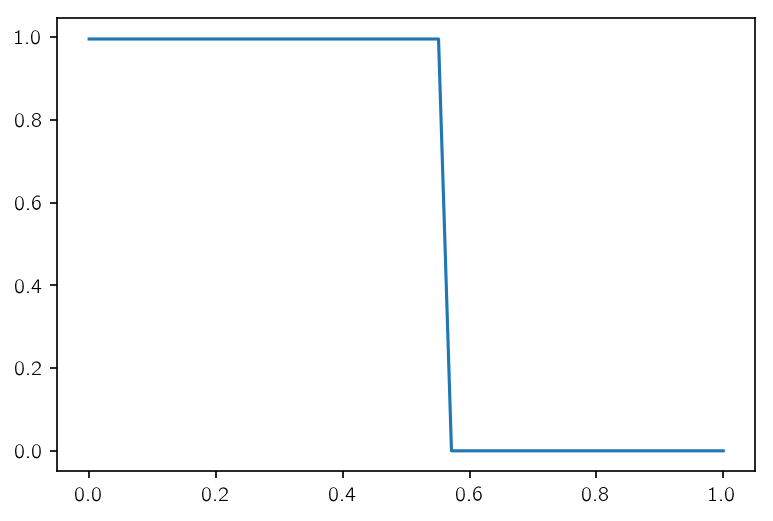

In [85]:
plt.plot(b_grid, v)

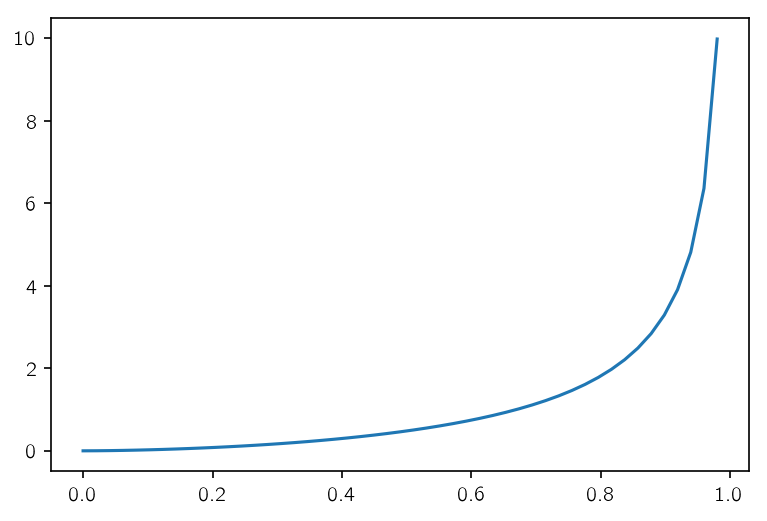

In [77]:
plt.plot(b_grid, session.run(b_vals))

In [11]:
mes_val = session.run(mes, feed_dict=feed)
tau_val = session.run(tau_pl, feed_dict=feed)

In [12]:
f = dict(feed)
f.update({b_pl: np.zeros(len(mes_val))})
mes_ref = session.run(mes, feed_dict=f)
tau_ref = session.run(tau_pl, feed_dict=f)

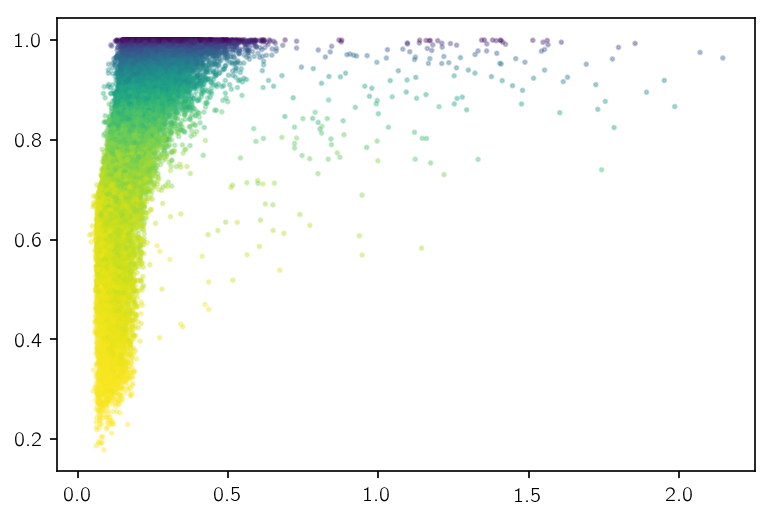

In [21]:
m = np.random.rand(len(tau_val)) < 0.01
plt.scatter(tau_val[m], mes_val[m] / mes_ref[m], s=3, c=flti.b[m], alpha=0.3)

In [78]:
y = np.array(flti.b)
bins = (
    np.linspace(0.1, 30, 100),
    np.linspace(y.min(), y.max(), 50)
)
b_x = 0.5*(bins[0][1:] + bins[0][:-1])
b_y = 0.5*(bins[1][1:] + bins[1][:-1])

ntot, _, _ = np.histogram2d(mes_ref, y, bins)
m = flti.Recovered == 1
nrec, _, _ = np.histogram2d(mes_ref[m], y[m], bins)
Z = nrec / ntot

X, Y = np.meshgrid(b_x, b_y, indexing="ij")
Z_mod = session.run(pdet, {mes: X.flatten()}).reshape(X.shape)

Text(0.5,0,'impact parameter')

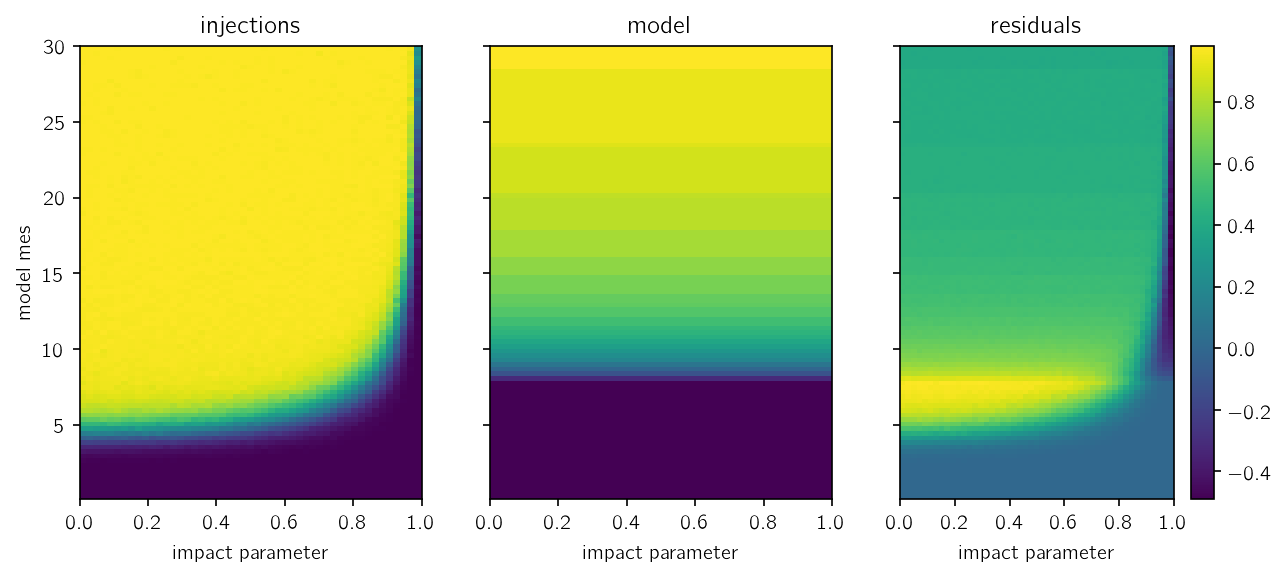

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolor(bins[1], bins[0], Z)
ax[0].set_title("injections")
ax[0].set_ylabel("model mes")
ax[0].set_xlabel("impact parameter")

ax[1].pcolor(bins[1], bins[0], Z_mod)
ax[1].set_title("model")
ax[1].set_xlabel("impact parameter")

c = ax[2].pcolor(bins[1], bins[0], Z - Z_mod)
fig.colorbar(c)
ax[2].set_title("residuals")
ax[2].set_xlabel("impact parameter")

In [22]:
opt.minimize(session, feed_dict=feed)
print(session.run(chi2, feed_dict=feed))

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 439.058078
  Number of iterations: 8
  Number of functions evaluations: 10
439.0580775763291


In [23]:
session.run(comp_pars)

[0.9957834368104727,
 array([-0.58909538,  0.12035858,  0.35010525, -2.59000351]),
 array([ 4.73561272, -0.54244269,  2.03827276,  0.15015404, -2.89132763])]

Text(0.5,0,'impact parameter')

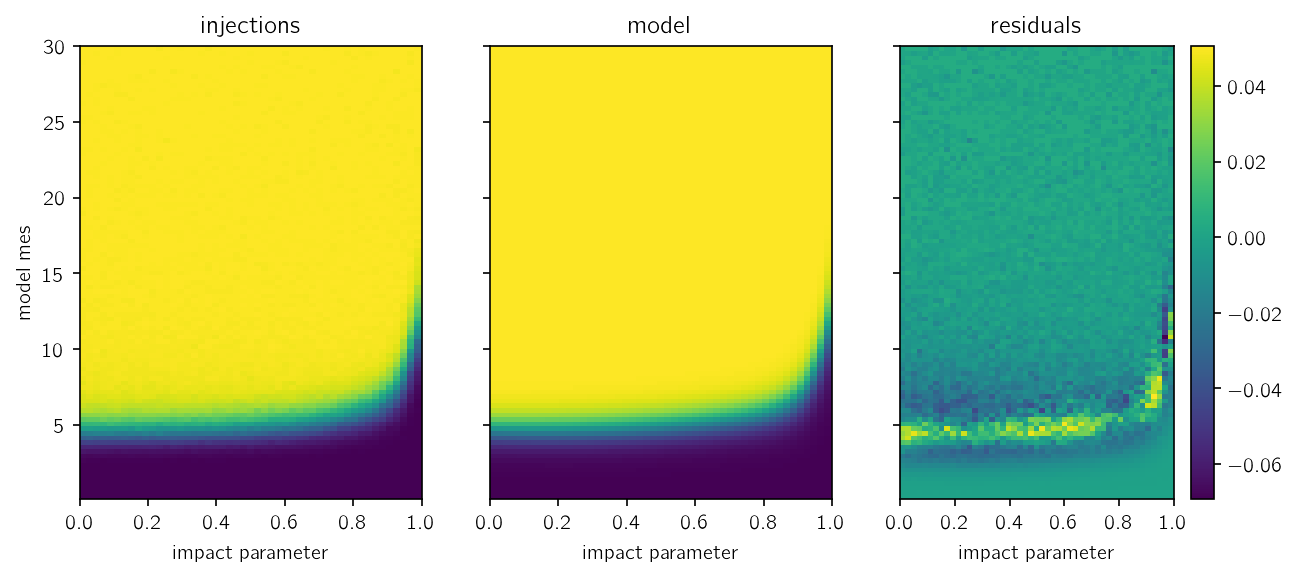

In [24]:
Z_mod = session.run(pdet, {mes: X.flatten(), b_pl: Y.flatten()}).reshape(X.shape)

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolor(bins[1], bins[0], Z)
ax[0].set_title("injections")
ax[0].set_ylabel("model mes")
ax[0].set_xlabel("impact parameter")

ax[1].pcolor(bins[1], bins[0], Z_mod)
ax[1].set_title("model")
ax[1].set_xlabel("impact parameter")

c = ax[2].pcolor(bins[1], bins[0], Z - Z_mod)
fig.colorbar(c)
ax[2].set_title("residuals")
ax[2].set_xlabel("impact parameter")

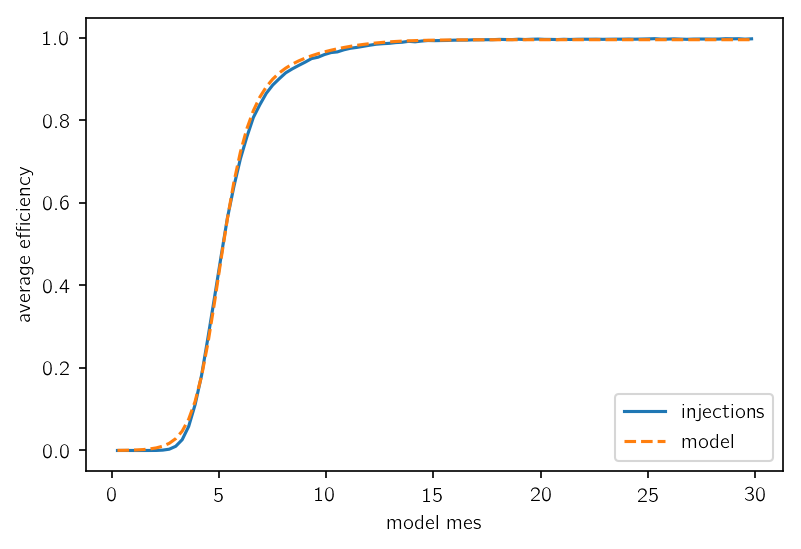

In [25]:
plt.plot(b_x, np.mean(Z, axis=1), label="injections")
plt.plot(b_x, np.mean(Z_mod, axis=1), "--", label="model")
plt.xlabel("model mes")
plt.ylabel("average efficiency")
plt.legend(loc=4);

Text(0,0.5,'average efficiency residual')

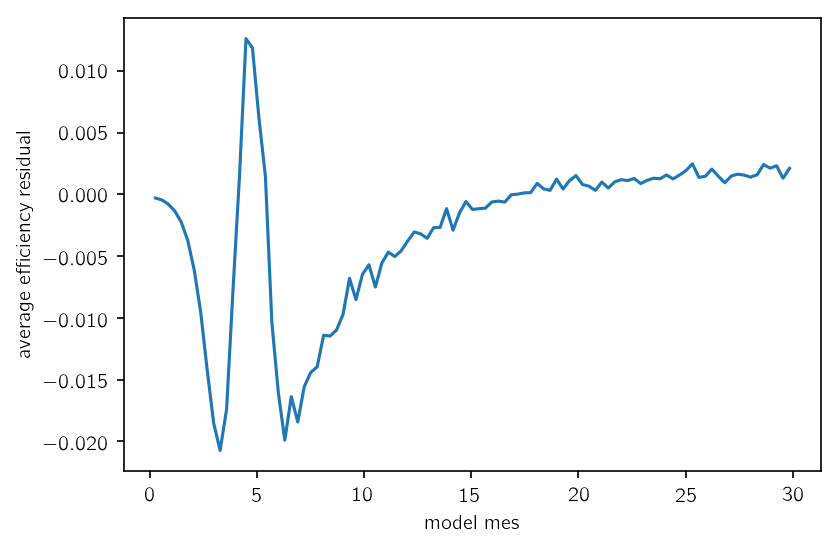

In [26]:
plt.plot(b_x, np.mean(Z, axis=1) - np.mean(Z_mod, axis=1))
plt.xlabel("model mes")
plt.ylabel("average efficiency residual")